# Introduction

Transformer-based models like DistilBERT have revolutionized natural language processing. In this project, we explore DistilBERT's effectiveness in sentiment analysis on IMDb movie reviews. Our aim is to train a model that accurately predicts whether a review is positive or negative.

# Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install pandas numpy seaborn matplotlib scikit-learn torch transformers datasets evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from evaluate import load
from transformers import pipeline

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Dataset & EDA

In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df.sample(5)

,review,sentiment
24380,Two great stars and a legendary Director creat...,positive
21657,"...there was ""Broadcast News,"" and what a good...",positive
22131,...from this awful movie! There are so many th...,negative
31224,Billed as the story of Steve Biko -- played ex...,positive
37406,- SMALL SPOILER HEREIN! - <br /><br />When I l...,positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.isna().sum()

,0
review,0
sentiment,0


## Visualising Target Values

In [ ]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

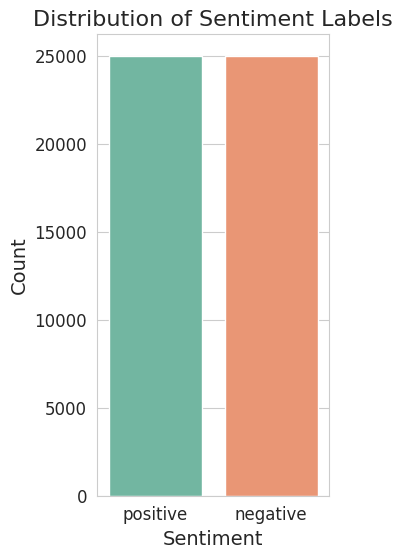

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(3, 6))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Distribution of Sentiment Labels', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

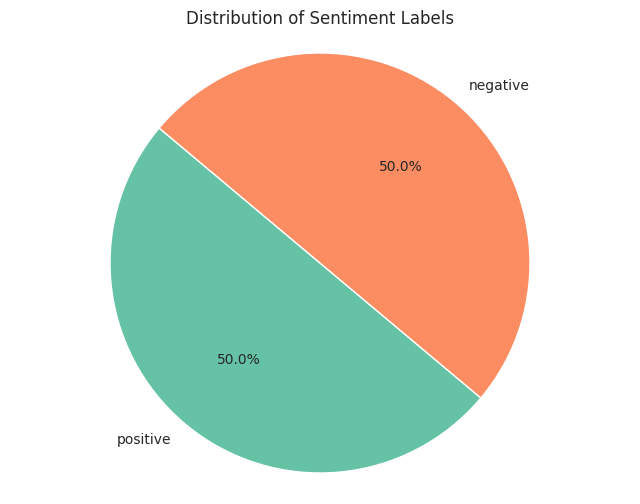

In [ ]:
label_counts = df['sentiment'].value_counts()
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Sentiment Labels')
plt.axis('equal')
plt.show()

# Model (DistilBERT)

## Preprocessing

### Label Encoding

In [ ]:
reviews = df['review'].tolist()
labels = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).tolist()

### Splitting the Dataset

In [ ]:
train_reviews, val_reviews, train_labels, val_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)

### Tokenization

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-uncased-finetuned-sst-2-english')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

In [ ]:
# Function for tokenizing the reviews

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True)

In [ ]:
train_encodings = tokenize_function(train_reviews)
val_encodings = tokenize_function(val_reviews)

In [ ]:
# Convert to Hugging Face Dataset format

train_dataset = Dataset.from_dict({
                                    'input_ids': train_encodings['input_ids'],
                                    'attention_mask': train_encodings['attention_mask'],
                                    'labels': train_labels
                                    })

val_dataset = Dataset.from_dict({
                                    'input_ids': val_encodings['input_ids'],
                                    'attention_mask': val_encodings['attention_mask'],
                                    'labels': val_labels
                                    })

dataset = DatasetDict({
                        'train': train_dataset,
                        'validation': val_dataset
                        })

## Model

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased-finetuned-sst-2-english', num_labels=2).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Define the evaluation metric

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

# Fine-Tuning the Model

In [ ]:
# Define training arguments

training_args = TrainingArguments(
    output_dir='./results',                     # Output directory for model checkpoints
    num_train_epochs=2,                         # Number of training epochs
    per_device_train_batch_size=16,             # Batch size per device (GPU/CPU)
    per_device_eval_batch_size=16,              # Evaluation batch size
    warmup_steps=100,                           # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                          # Weight decay for regularization
    logging_dir='./logs',                       # Directory for logging
    logging_steps=10,                           # Interval for logging updates
    evaluation_strategy='epoch',                # Evaluate at each epoch
    report_to="none",                           # Disable reporting to Hugging Face Hub
    push_to_hub=False,                          # Do not push to Hugging Face Hub
    fp16=True,                                  # Enable mixed precision
)

In [ ]:
# Initialize Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics
)

In [ ]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.240700,0.205633,0.927100
2,0.110900,0.219262,0.940400


TrainOutput(global_step=5000, training_loss=0.1730336150214076, metrics={'train_runtime': 1767.3491, 'train_samples_per_second': 45.266, 'train_steps_per_second': 2.829, 'total_flos': 1.059739189248e+16, 'train_loss': 0.1730336150214076, 'epoch': 2.0})

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.219262033700943, 'eval_accuracy': 0.9404, 'eval_runtime': 60.1919, 'eval_samples_per_second': 166.135, 'eval_steps_per_second': 10.383, 'epoch': 2.0}


# Conclusion

## Our experiment with **DistilBERT** on IMDb reviews achieved promising results, reaching an accuracy of ***94%***. This shows how powerful transformer-based models can be in understanding and analyzing text. DistilBERT, inspired by the attention mechanism introduced in the paper *"Attention Is All You Need,"* effectively captures the meaning and context of words, making it highly accurate for sentiment analysis.

Using a **GPU** for fine-tuning, the model performed exceptionally well after just one epoch of training. This demonstrates the effectiveness of transfer learning, where pre-trained models like DistilBERT can be adapted quickly to new tasks with great results. Further improvements could be made by adjusting the number of epochs, tuning hyperparameters, or increasing batch size.

In summary, transformer models like DistilBERT offer a powerful and efficient approach to sentiment analysis, providing a strong foundation for future work.